<a href="https://colab.research.google.com/github/IAlam0819/COVID-19-Patients-Detection-and-Triaging/blob/main/Covid19_ChestCTscan_VGG19ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

In [ ]:
# add preprocessing layer to the front of VGG
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(vgg.output)
x = Dense(64, activation='relu')(x)
prediction = Dense(1, activation='sigmoid')(x)

In [ ]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [ ]:
# view the structure of the model
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [ ]:
from tensorflow.keras.optimizers import RMSprop
model.compile(
  loss='binary_crossentropy',
  optimizer=RMSprop(lr=0.001),
  metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/content/drive/My Drive/CT_Scan_DataSet/Training',  # This is the source directory for training images
        target_size=(224, 224), 
        batch_size=64,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        '/content/drive/My Drive/CT_Scan_DataSet/Validation',  # This is the source directory for training images
        target_size=(224, 224),  
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 610 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [ ]:
r = model.fit(
  train_generator,
  validation_data=validation_generator,
  epochs=50,
  steps_per_epoch=len(train_generator),
  validation_steps=len(validation_generator)
)

Epoch 1/50
10/10 [==============================] - 14s 1s/step - loss: 0.7865 - accuracy: 0.8836 - val_loss: 0.7735 - val_accuracy: 0.7800
Epoch 2/50
10/10 [==============================] - 6s 621ms/step - loss: 0.0335 - accuracy: 0.9984 - val_loss: 0.7148 - val_accuracy: 0.7800
Epoch 3/50
10/10 [==============================] - 6s 618ms/step - loss: 0.0463 - accuracy: 0.9902 - val_loss: 4.4238 - val_accuracy: 0.5000
Epoch 4/50
10/10 [==============================] - 6s 639ms/step - loss: 0.5925 - accuracy: 0.8836 - val_loss: 0.5645 - val_accuracy: 0.7500
Epoch 5/50
10/10 [==============================] - 6s 632ms/step - loss: 0.3348 - accuracy: 0.8820 - val_loss: 1.0198 - val_accuracy: 0.6400
Epoch 6/50
10/10 [==============================] - 6s 637ms/step - loss: 0.0734 - accuracy: 0.9787 - val_loss: 0.5994 - val_accuracy: 0.7600
Epoch 7/50
10/10 [==============================] - 6s 628ms/step - loss: 0.5095 - accuracy: 0.7820 - val_loss: 0.6257 - val_accuracy: 0.7800
Epoch 8/

In [ ]:
pred = model.predict_generator(validation_generator)
test = validation_generator.classes

In [ ]:
for index, item in enumerate(pred):
  if (item > 0.5):
    pred[index] = 1
  else:
    pred[index] = 0

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix
#confusion_matrix
conf_matrix = confusion_matrix(test, pred)
print(conf_matrix)

[[17 33]
 [21 29]]


In [ ]:
#accuracy_score of the model
accuracy = accuracy_score(test, pred)
print(accuracy)

0.46


In [ ]:
#classification report
from sklearn.metrics import classification_report
report = classification_report(test, pred)
print(report)

              precision    recall  f1-score   support

           0       0.51      0.40      0.45        50
           1       0.51      0.62      0.56        50

    accuracy                           0.51       100
   macro avg       0.51      0.51      0.50       100
weighted avg       0.51      0.51      0.50       100



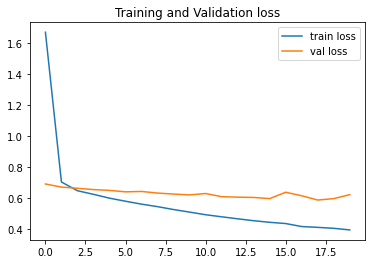

<Figure size 432x288 with 0 Axes>

In [ ]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

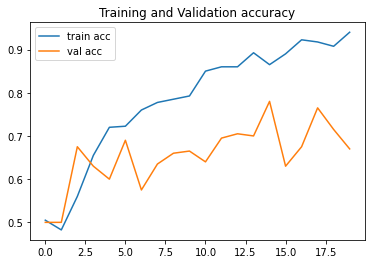

<Figure size 432x288 with 0 Axes>

In [ ]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')